## Bayesian GLMs using Bambi

We now want to use bayesian methods within a general linear model. We could do this using pymc. In fact we can build almost any model we want using pymc to do inference. However, to get started I would recommend using Bambi to get familiar with the bayesian world. Bambi has two main advantages for newcomers.

1. You can write models using the Wilkinson notation (just like in lme4 or brms)
2. You dont need to specify priors (which can be a bit intimidating when you are just getting started)

Also bambi builds on pymc so transitioning should be easy :)

Check out this webpage for some more sophisticated and detailed information on how to get started.

https://bambinos.github.io/bambi/notebooks/getting_started.html

In [1]:
import bambi as bmb

In [2]:
#Some other imports
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks')
sns.set_context('poster')

In [3]:
df = pd.read_csv('introduction_python/data/netflix_merged.csv')

cols_of_interest = ['Days In Top 10', 'year', 'Netflix Exclusive', 'Viewership Score']

df_sel = df[cols_of_interest]
df_sel.columns = [key.replace(' ', '_') for key in cols_of_interest] #bambi formulas have some problems with whitespaces

## Quick data check

Lets look at our data again. We noticed before that "Days In Top 10" is not really normally distributed. 
We can also see that the data represents counts. Counts will always be absolute values starting from 0.
A good distribution to model count data is the poisson distribution.

See https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.Poisson.html

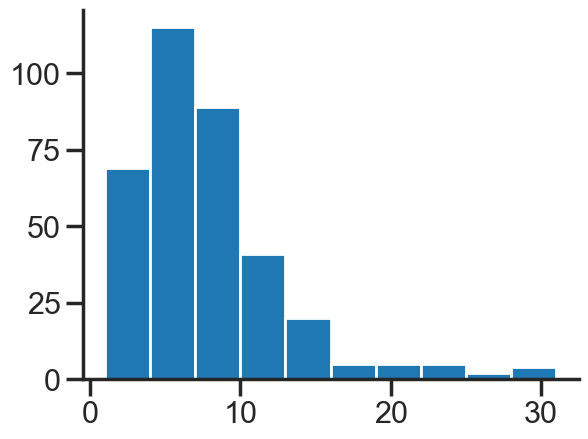

In [4]:
plt.hist(df_sel['Days_In_Top_10'])
sns.despine()

In [5]:
md = bmb.Model(data=df_sel, 
               formula='Days_In_Top_10 ~ 0 + Netflix_Exclusive', # Adding a 0 fits a model without intercept. Just doing this here to help with visualization later
               family='poisson', #family refers to the output variable e.g. "Days In Top 10"
               link='log') 
#The link function is used to link the input variables with the distribution of the output variable.
#Think of it as a 'scaling' function for the input variables

In [6]:
#now lets press the inference button and run our first model
mdf = md.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Netflix_Exclusive]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


## Lets investigate our model

After bambi did its thing we can investigate the outcomes of our analysis using arviz. Arviz is a package that can be used for an exploratory analysis of your model outcomes. Arviz is pretty agnostic and can work with a wide variety of bayesian models.
As a first shot its always good to do a summary of our model

In [7]:
az.summary(mdf)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Netflix_Exclusive[No]   1.867  0.030   1.812    1.926        0.0      0.0   
Netflix_Exclusive[Yes]  2.109  0.026   2.060    2.158        0.0      0.0   

                        ess_bulk  ess_tail  r_hat  
Netflix_Exclusive[No]     4071.0    3055.0    1.0  
Netflix_Exclusive[Yes]    3870.0    2839.0    1.0

In the summary of the first 4 columns (mean, sd, hdi_3%, hdi_97%) we can find descriptive information related to our beta coefficients. The last 3 columns (ess_bulk, ess_tail, r_hat) contain very important information about our model diagnostics.
As a rule of thumb we want an rhat < 1.05 and an effective sample size (ess) > 400. For more detailed information see...

Vehtari, A., Gelman, A., Simpson, D., Carpenter, B., & Bürkner, P.-C. (2021). Rank-Normalization, Folding, and Localization: An Improved R^ for Assessing Convergence of MCMC (with Discussion). Bayesian Analysis, 16(2). https://doi.org/10.1214/20-BA1221




## So what does all of that mean??

When we fit our model using no intercept (e.g. Days_In_Top_10 ~ 0 + Netflix_Exclusive). We obtain a coefficient for each class of our categorical variables (Yes/No). When we fit our model with an intercept (e.g. Days_In_Top_10 ~ 1 + Netflix_Exclusive) one class is used as the intercept and the beta coefficient for the residual class is to be interpreted in relation to this (i.e. an a beta > 0 means higher than the intercept class and a beta < 0 means lower than the intercept class). In our case it really doesnt matter whether or not we fit with an intercept. I show this below, but also feel free to checkout this example by the bambi people.

https://bambinos.github.io/bambi/notebooks/t-test.html


In [8]:
mdf2 = bmb.Model(data=df_sel, 
               formula='Days_In_Top_10 ~ 1 + Netflix_Exclusive',
               family='poisson', #family refers to the output variable e.g. "Days In Top 10"
               link='log').fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Netflix_Exclusive]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [9]:
az.summary(mdf2)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept               1.866  0.029   1.810    1.919      0.000      0.0   
Netflix_Exclusive[Yes]  0.241  0.038   0.171    0.313      0.001      0.0   

                        ess_bulk  ess_tail  r_hat  
Intercept                 4247.0    3062.0    1.0  
Netflix_Exclusive[Yes]    4124.0    2967.0    1.0

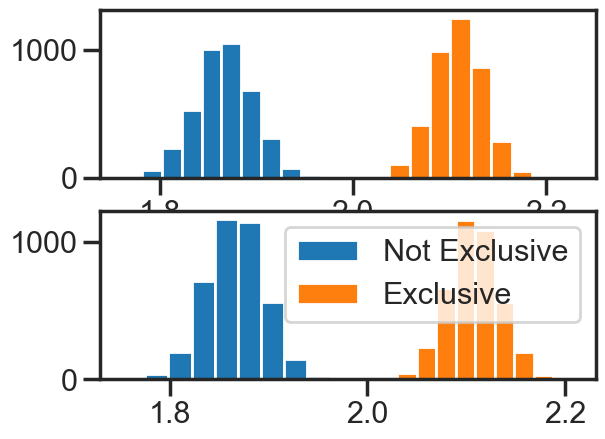

In [10]:
#lets visualize the posteriors
#Note: small residual differences might be due to sampling
fig, axes = plt.subplots(nrows=2)

axes[0].hist(mdf.posterior['Netflix_Exclusive'][:,:,0].to_numpy().flatten(), label='Not Exclusive')
axes[0].hist(mdf.posterior['Netflix_Exclusive'][:,:,1].to_numpy().flatten(), label='Exclusive')


intercept = mdf2.posterior['Intercept'].to_numpy().flatten()
exclusive_true = intercept + mdf2.posterior['Netflix_Exclusive'].to_numpy().flatten()

axes[1].hist(intercept, label='Not Exclusive')
axes[1].hist(exclusive_true, label='Exclusive')

plt.legend()

## Now lets run the proper model

Controlling for the impact of Viewership scores

In [11]:
md_final = bmb.Model(data=df_sel, 
                      formula='Days_In_Top_10 ~ 1 + Netflix_Exclusive + Viewership_Score',
                      family='poisson', 
                      link='log')

mdf_final = md_final.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Netflix_Exclusive, Viewership_Score]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 277 seconds.


In [12]:
az.summary(mdf_final)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept               1.453  0.034   1.392    1.520      0.001    0.000   
Netflix_Exclusive[Yes] -0.165  0.044  -0.246   -0.081      0.001    0.001   
Viewership_Score        0.020  0.001   0.019    0.021      0.000    0.000   

                        ess_bulk  ess_tail  r_hat  
Intercept                 4536.0    3473.0    1.0  
Netflix_Exclusive[Yes]    2956.0    2946.0    1.0  
Viewership_Score          2310.0    2681.0    1.0

## Netflix does not seem to push its exclusive Titles.

Our results show that the previous effect reverses.. 
After statistically controlling for Viewership Scores we find that Netflix Exclusive shows stay in fact slightly shorter in the top 10 than shows that are not exclusive. 

Lets quickly do some posterior predictive checks to see how well our model captures the distribution of our data.

<Axes: xlabel='Days_In_Top_10 / Days_In_Top_10'>

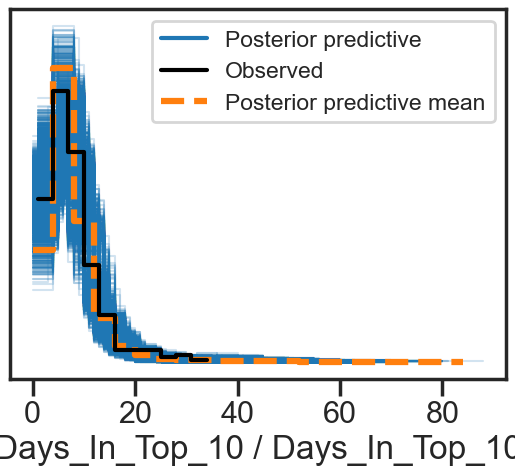

In [13]:
#looks pretty good
md_final.predict(mdf_final, kind='pps')
az.plot_ppc(mdf_final)